# Practical Introduction to LangGraph

# States

Data structure that get's updated when we execute a graph.

# Nodes

Functions where we perform updates to states by adding or transforming the keys 
of that state.

# Edges

Connect the nodes together (they can be direct a->b or conditional a->b or a->c).

# Graph (build & invoke)

The [DAG cycle](https://en.wikipedia.org/wiki/Directed_acyclic_graph) that combines the entire thing.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

# State

State as a simple data structure that we update as we execute the graph.

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):    
    state_before_node1: str
    state_after_node1: int

Now, we define a node where the computation of our graph will happen.

In [4]:
from typing import Literal
import random

def node1(state):
    print("Passing by node 1")
    state["state_after_node1"] = "Passed by node1"
    return state

Finally, we put everything together including the edges that will connect the entry point of our graph to the end.

In [5]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")

builder.add_edge("node1", END)

graph = builder.compile()

We can now visualize our graph.

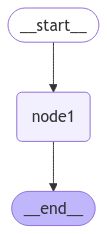

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"state_before_node1": ""})

Passing by node 1


{'state_before_node1': '', 'state_after_node1': 'Passed by node1'}

# Routing

<img src="./2025-02-10-12-16-57.png" width=50%>

We can also create a graph that routes between options easily using a node with some conditional logic, and then a special type of edge
`.add_conditional_edges()` that will integrate that conditional logic into the graph.

In [44]:
from typing import Literal
import random

def node1(state):
    print("Passing by node 1")
    return state

def node2(state):
    print("Passing by node 2")
    state["graph_state"] = "node 2" 
    return state

def node3(state):
    print("Passing by node 3")
    state["graph_state"] = "node 3"
    return state

# Implementing some conditional logic
def decision_node(state) -> Literal["node2", "node3"]:
    
    user_input = state["graph_state"]
    print(user_input)
    
    if user_input=="2":
        return "node2"
    else:
        return "node3"

In [45]:
class State(TypedDict):
    graph_state: str
    

builder = StateGraph(State)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1",decision_node)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

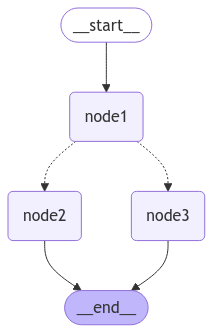

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
graph.invoke({"graph_state": "2"})

Passing by node 1
2
Passing by node 2


{'graph_state': 'node 2'}

In [51]:
graph.invoke({"graph_state": "3"})

Passing by node 1
3
Passing by node 3


{'graph_state': 'node 3'}